# <span style=color:darkblue>CLUSTERING (KPrototypes)</span>

**REFERENCES**

- https://towardsdatascience.com/clustering-on-numerical-and-categorical-features-6e0ebcf1cbad
- https://www.analyticsvidhya.com/blog/2021/06/kmodes-clustering-algorithm-for-categorical-data/
- https://medium.com/analytics-vidhya/clustering-on-mixed-data-types-in-python-7c22b3898086
- https://towardsdatascience.com/the-k-prototype-as-clustering-algorithm-for-mixed-data-type-categorical-and-numerical-fe7c50538ebb
- https://decoderai.com/customer-segmentation-project-using-k-prototypes-with-code-source/

**SELECCIÓN DE VARIABLES CATEGORICAS Y NUMERICAS**
- https://machinelearningmastery.com/feature-selection-with-categorical-data/ - Categóricas
- https://towardsdatascience.com/feature-selection-techniques-for-classification-and-python-tips-for-their-application-10c0ddd7918b - Numéricas
- https://www.dataknowsall.com/featureselection.html - Mixed dtypes
- https://www.analyticsvidhya.com/blog/2020/10/feature-selection-techniques-in-machine-learning/ - Mixed dtypes

In [1]:
# Librerias
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_selector as selector
from kmodes.kprototypes import KPrototypes
from kneed import KneeLocator

# <span style=color:darkblue>Funciones</span>


In [2]:
############################ FUNCIONES  ######################################################################

# Función para ver qué variables son más importantes    
def cat_var_importance(df):
    
    # Seleccionamos las variables categóricas
    cat_vars = df.select_dtypes(include = 'object')
    cluster_var = df["GrupoEdad"].values

    # Codificar las variables categóricas utilizando OrdinalEncoder
    encoder = OrdinalEncoder()
    encoder.fit(cat_vars)
    X_encoded = encoder.transform(cat_vars)

    # Seleccionar todas las variables utilizando SelectKBest y chi2
    selector = SelectKBest(score_func = chi2, k='all')
    selector.fit(X_encoded, cluster_var)
    X_selected = selector.transform(X_encoded)

    for i in range(len(selector.scores_)):
        print("Feature %d: %f" % (i, selector.scores_[i]))
        
    # Dibujamos las variables más importantes
    names = []
    values = []
    for i in range(len(selector.scores_)):
        names.append(cat_vars.columns[i])
        values.append(selector.scores_[i])

    chi_list = zip(names, values)

    # Plot
    plt.figure(figsize=(10,4))
    sns.barplot(x=names, y=values)
    plt.xticks(rotation = 90)
    plt.show()
    

# Función de correlación
def correlation_matrix(matrix):
    
    # Matrix
    corr = matrix.corr()
    
    # Plot
    f, ax = plt.subplots(figsize = (12,7))
    sns.heatmap(corr, cmap = 'Blues', annot = True, square = False, ax = ax)
    plt.title('Pearson Correlation of Features')
    plt.yticks(rotation=45);

In [3]:
# Carga de los datos
pd.set_option('display.max_columns', None)
ahogamientos = pd.read_csv("/Users/adrianova/Desktop/git/TFM - Notebooks/datos_ahogamiento_meteorologicos2.csv",  encoding='utf-8')
ahogamientos.head(2)

,Fecha,IdAhogado,IdPersona,Localidad,Provincia,CCAA,Hora,Latitud,Longitud,Sexo,Edad,Nacionalidad,Origen,Extraccion,Titular,Causa,TipoAhogamiento,Factor,Intervencion,Pronostico,Localizacion,Riesgo,Reanimacion,Vigilancia,Actividad,Deteccion,Enlace1,Indicador,Estacion,Altitud,TempMed,Precip,TempMin,TempMax,DirViento,VelMedViento,RachaViento,TiempoSol,PresionMax,PresionMin
0,30-12-2020,7432,8532,Torredembarra,Tarragona,Cataluña,NaN,41.130523,1.395311,NaN,NaN,España,NaN,Embarcación de rescate,Encuentran un cadáver flotando en el mar cerca...,NaN,Posible Ahogamiento,NaN,Recuperación de cadaver,Ahogamiento mortal,Franja costera o alta mar,NaN,Recuperacion de cadaver,No vigilado,NaN,Ciudadano,#https://www.diarimes.com/es/noticias/camp_tar...,9981A,ESTACIÓN DE TORTOSA (ROQUETES),50,10.0,0.0,8.0,12.1,30.0,4.4,22.8,3.9,1010.0,1000.9
1,29-12-2020,7431,8531,"Cádiz, Playa de Santa Maria del Mar",Cádiz,Andalucía,17:48,36.519991,-6.287258,NaN,NaN,España,NaN,Ciudadano,Evacuada al hospital en estado grave una perso...,NaN,Posible Ahogamiento,NaN,Recuperación de cadaver,Ahogamiento no mortal con hospitalizacion,Playas sin vigilancia,NaN,SVA por SEM,No vigilado,Natación recreativa,Ciudadano,#https://elcorreoweb.es/andalucia/encuentran-u...,5973,CÁDIZ,2,12.2,0.2,9.2,15.3,32.0,3.3,9.4,NaN,1017.0,1011.4


In [4]:
# 8015 observaciones y 40 columnas
ahogamientos.shape

(8015, 40)

## <span style=color:darkblue>PRIMERA APROXIMACIÓN</span>
### <span style=color:darkblue>Limpieza de los datos</span>

+ Hay columnas que de por si no son relevantes a la hora de aplicar algoritmos de aprendizaje automático como lo son los identificadores o variables que son explicadas por otras:

    - **IdAhogado:** es un identificador
    - **IdPersona:** es un identificador
    - **Indicador:** es un identificador 
    - **Localidad:** queda explicada por CCAA y con menos categorías
    - **Provincia:** queda explicada por CCAA y con menos categorías
    - **Fecha, Hora, Titular, Enlace1, Estación**: no aporta información

In [5]:
# Eliminamos las columnas que estamos 100% seguros que no aportan valor
ahogamientos_df = ahogamientos.copy()
ahogamientos_df.drop(["IdAhogado", "IdPersona","Indicador", "Localidad", \
                      "Provincia", "Fecha", "Hora", "Titular", "Enlace1", "Estacion"], axis = 1, inplace = True)
ahogamientos_df.head(2)

,CCAA,Latitud,Longitud,Sexo,Edad,Nacionalidad,Origen,Extraccion,Causa,TipoAhogamiento,Factor,Intervencion,Pronostico,Localizacion,Riesgo,Reanimacion,Vigilancia,Actividad,Deteccion,Altitud,TempMed,Precip,TempMin,TempMax,DirViento,VelMedViento,RachaViento,TiempoSol,PresionMax,PresionMin
0,Cataluña,41.130523,1.395311,NaN,NaN,España,NaN,Embarcación de rescate,NaN,Posible Ahogamiento,NaN,Recuperación de cadaver,Ahogamiento mortal,Franja costera o alta mar,NaN,Recuperacion de cadaver,No vigilado,NaN,Ciudadano,50,10.0,0.0,8.0,12.1,30.0,4.4,22.8,3.9,1010.0,1000.9
1,Andalucía,36.519991,-6.287258,NaN,NaN,España,NaN,Ciudadano,NaN,Posible Ahogamiento,NaN,Recuperación de cadaver,Ahogamiento no mortal con hospitalizacion,Playas sin vigilancia,NaN,SVA por SEM,No vigilado,Natación recreativa,Ciudadano,2,12.2,0.2,9.2,15.3,32.0,3.3,9.4,NaN,1017.0,1011.4


In [6]:
# 8015 observaciones y 30 columnas
ahogamientos_df.shape

(8015, 30)

+ De las variables restantes pueden haber algunas más interesantes que otras para el modelo clustering KPrototypes. Para ello es importante conocer los valores faltantes que nos puede ayudar a determinar que variables son relevantes y cuáles no.

In [7]:
round(ahogamientos_df.isna().sum()/ahogamientos_df.shape[0],4) * 100

CCAA                0.00
Latitud             0.00
Longitud            0.00
Sexo                4.97
Edad               19.70
Nacionalidad        1.16
Origen             43.87
Extraccion          1.32
Causa              28.10
TipoAhogamiento     0.30
Factor             58.22
Intervencion        0.97
Pronostico          0.26
Localizacion        0.00
Riesgo             61.37
Reanimacion         2.83
Vigilancia          0.34
Actividad           4.15
Deteccion           1.71
Altitud             0.00
TempMed             0.42
Precip              4.63
TempMin             0.42
TempMax             0.36
DirViento           2.28
VelMedViento        2.01
RachaViento         2.28
TiempoSol           7.70
PresionMax          0.71
PresionMin          0.70
dtype: float64

+ Hay ciertas variables que pueden ser importantes para revelar patrones de comportamiento como lo son el origen, la causa, el factor y el riesgo de ahogamiento pero que mantienen demasiados valores faltantes y que para una primera aproximación nos desharemos de ellas. 


+ Por otro lado, la variable Edad tiene aproximadamente un 20% de valores faltantes, y para una primera aproximación solo nos quedaremos con aquellas observaciones para los que hay datos, ya que considero que imputar con la media o mediana puede influir en los resultados.


+ Para las variables categóricas realizaremos imputación de missings con la moda, ya que el número de valores faltantes es muy bajo.


+ Para las variables meteorológicas realizaremos imputación de missings sobre la mediana, ya que el número de valores faltantes es muy bajo.

In [8]:
# Eliminamos los valores en que la variable Edad tiene Nans por conveniencia
ahogamientos_df = ahogamientos_df.dropna(subset = ["Edad"])

# Eliminamos las variables Origen, Causa, Factor y Riesgo por almacenar demasiados valores faltantes
ahogamientos_df.drop(["Origen", "Causa",'Factor', "Riesgo"], axis = 1, inplace = True)

In [9]:
# Imputación de missings con el valor más frecuente
no_data_columns = ["Sexo", "Nacionalidad", "Extraccion", "TipoAhogamiento", "Intervencion", "Pronostico", "Reanimacion", "Vigilancia", "Actividad", "Deteccion"]
      
for var in no_data_columns:
    moda = ahogamientos_df[var].mode().iloc[0]
    ahogamientos_df[var] = ahogamientos_df[var].fillna(moda)

In [10]:
# Realizamos imputación de missings sobre las variables meteorologicas
median_imputation = ["TempMed", "Precip", "TempMin", "TempMax", "DirViento",\
"VelMedViento", "RachaViento","TiempoSol", "PresionMax", "PresionMin"]
# Calculo de la mediana de cada variable
medians = ahogamientos_df[median_imputation].median()

for median in median_imputation:
    ahogamientos_df[median] = ahogamientos_df[median].fillna(medians[median])

+ Previamente a realizar técnicas de aprendizaje automático habíamos analizado si había diferencias significativas en el número de ahogamientos dependiendo del grupo de edad. Para ello vamos asociar cada grupo de edad un valor entre 1-5 dependiendo al grupo de edad al que pertenece.

+ Hay que ir con cuidado a la hora de introducirla en el modelo, ya que está altamente correlacionada con la variable edad. 

In [11]:
# Variable que asigna valores entre 1 y 5 dependiendo al grupo que pertenece
conditions = [
    (ahogamientos_df['Edad'] > 0) & (ahogamientos_df['Edad'] <= 15),
    (ahogamientos_df['Edad'] >= 16) & (ahogamientos_df['Edad'] <= 30),
    (ahogamientos_df['Edad'] >= 31) & (ahogamientos_df['Edad'] <= 45),
    (ahogamientos_df['Edad'] >= 46) & (ahogamientos_df['Edad'] <= 60),
    (ahogamientos_df['Edad'] >= 61)
]

values = [1, 2, 3, 4, 5]

ahogamientos_df['GrupoEdad'] = np.select(conditions, values)

+ Nos queda un último paso y es el de convertir las variables categóricas a 'object' y las variables numéricas a "float", para aquellas variables que no tienen el tipo de dato correcto.

In [12]:
# Variable Latitud y Longitud
ahogamientos_df[["Latitud", "Longitud"]] = ahogamientos_df[["Latitud", "Longitud"]].apply(pd.to_numeric, errors = 'coerce')

### <span style=color:darkblue>Selección de variables</span>

+ Una vez tenemos los datos que queremos tener en cuenta y limpios procedemos a seleccionar aquellas variables que van a participar dentro del algoritmo KPrototype.

In [13]:
ahogamientos_df.head(2)

,CCAA,Latitud,Longitud,Sexo,Edad,Nacionalidad,Extraccion,TipoAhogamiento,Intervencion,Pronostico,Localizacion,Reanimacion,Vigilancia,Actividad,Deteccion,Altitud,TempMed,Precip,TempMin,TempMax,DirViento,VelMedViento,RachaViento,TiempoSol,PresionMax,PresionMin,GrupoEdad
2,País Vasco,43.317215,-1.977996,Hombre,47.0,España,Cuerpo de Seguridad o Emergencias,Ahogamiento secundario a accidente,Recuperación de cadaver,Ahogamiento mortal,"Puertos, embarcaderos, amarres",Recuperacion de cadaver,No vigilado,Circulación en vehiculo,"Acompañante, familiar, amigo",251,5.4,36.6,3.8,7.0,26.0,8.9,18.1,0.0,977.5,968.1,4
3,País Vasco,43.317215,-1.977996,Hombre,33.0,España,No preciso extraccion,Perdida de Control,Recuperación de cadaver,Rescate y traslado a supervisión médica,"Puertos, embarcaderos, amarres",Sin Reanimacion,No vigilado,Circulación en vehiculo,"Acompañante, familiar, amigo",251,5.4,36.6,3.8,7.0,26.0,8.9,18.1,0.0,977.5,968.1,3


In [14]:
# 6436 observaciones y 27 columnas
ahogamientos_df.shape

(6436, 27)

#### <span style=color:darkblue>Datos categóricos</span>

Feature 0: 85.589672
Feature 1: 28.744553
Feature 2: 27.550063
Feature 3: 275.030926
Feature 4: 244.721151
Feature 5: 63.752047
Feature 6: 3035.348964
Feature 7: 195.069313
Feature 8: 1001.211849
Feature 9: 130.307084
Feature 10: 142.451610
Feature 11: 265.970848


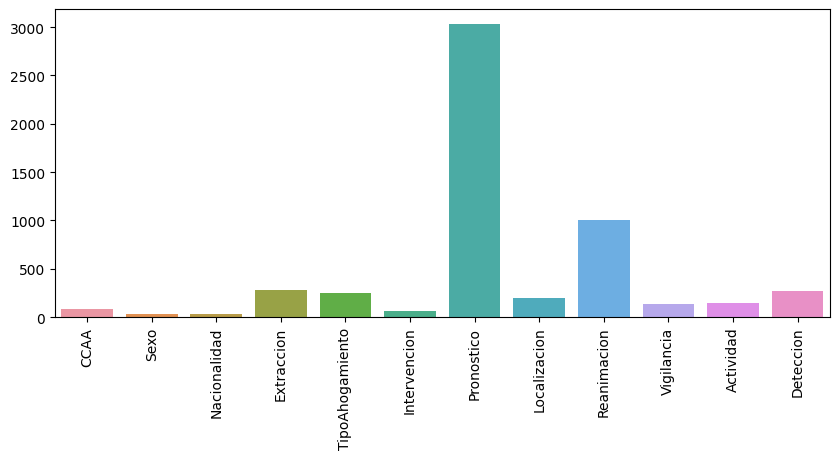

In [15]:
# Miramos que variables son más importantes para introducir en el cluster
cat_var_importance(ahogamientos_df)

+ Se observa como las variables más relevantes para el modelo son: Pronostico y Reanimación. Luego con menor peso Detección, Extracción y TipoAhogamiento. 

#### <span style=color:darkblue>Datos numéricos</span>

In [16]:
# Seleccionamos únicamente variables numéricas
num_vars = ahogamientos_df.select_dtypes(include = ['float64', 'int64'])
num_vars = num_vars.iloc[:, :-1]
num_vars.head()

,Latitud,Longitud,Edad,Altitud,TempMed,Precip,TempMin,TempMax,DirViento,VelMedViento,RachaViento,TiempoSol,PresionMax,PresionMin
2,43.317215,-1.977996,47.0,251,5.4,36.6,3.8,7.0,26.0,8.9,18.1,0.0,977.5,968.1
3,43.317215,-1.977996,33.0,251,5.4,36.6,3.8,7.0,26.0,8.9,18.1,0.0,977.5,968.1
5,28.485031,-14.094721,63.0,24,19.6,0.0,15.2,24.0,3.0,3.9,8.9,9.1,1011.0,1008.5
6,28.485031,-14.094721,53.0,24,19.6,0.0,15.2,24.0,3.0,3.9,8.9,9.1,1011.0,1008.5
7,28.396314,-16.651826,32.0,32,19.2,0.0,17.4,20.9,2.0,1.4,4.7,6.5,1011.8,1008.0


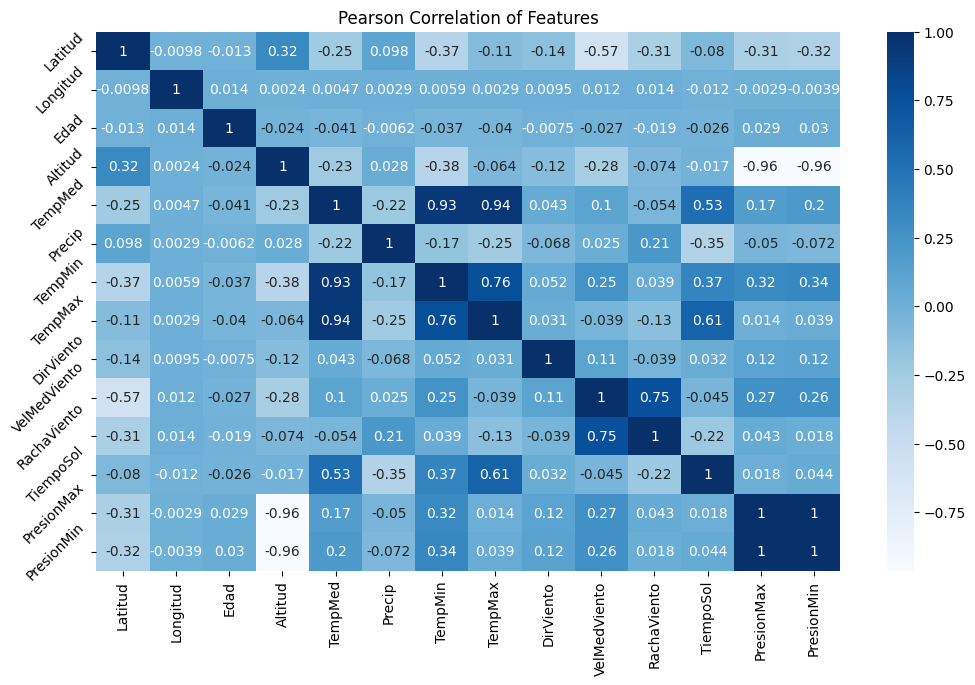

In [17]:
# Miramos la correlación entre las variables numéricas
correlation_matrix(num_vars)

+ Podemos ver varias variables con correlaciones muy altas entre ellas que pueden hacer que nuestro modelo interprete incorrectamente, por lo que debemos seleccionar:


  - La temperatura media tiene correlaciones muy altas con las variables temperatuda mínima y máxima como es de esperar, ya que cuando la temperatura máxima y mínima de un día frío es baja, es de esperar que la temperatura media del día también lo sea y viceversa con las temperaturas para un día caluroso.
    
    
  - La velocidad media del viento y la racha de viento tienen una correlación del 75%, de modo que solo nos quedaremos con la racha del viento, ya que la variable velocidad media del viento está fuertemente correlacionada con la variable altitud, aunque nos podríamos quedar con velocidad media del viento.
 
    
    
  - La variable TempSol esta correlacionada con la temperatura media, pero al no ser una relación fuerte la mantendremos en el modelo.
    
    
  - La altitud esta intrísicamente relacionada con la presión mínima y máxima, ya que a menor altitud mayor presión y viceversa. Por lo que decidimos quedarnos únicamente con la altitud, ya que presion max y min están a su vez relacionadas porque cuando en una sube, la otra baja. 

In [18]:
# Eliminamos las variables que están altamente correlacionadas
columns = ["TempMin", "TempMax", "VelMedViento", "PresionMax", "PresionMin"]
num_vars = num_vars.drop(columns, axis = 1)

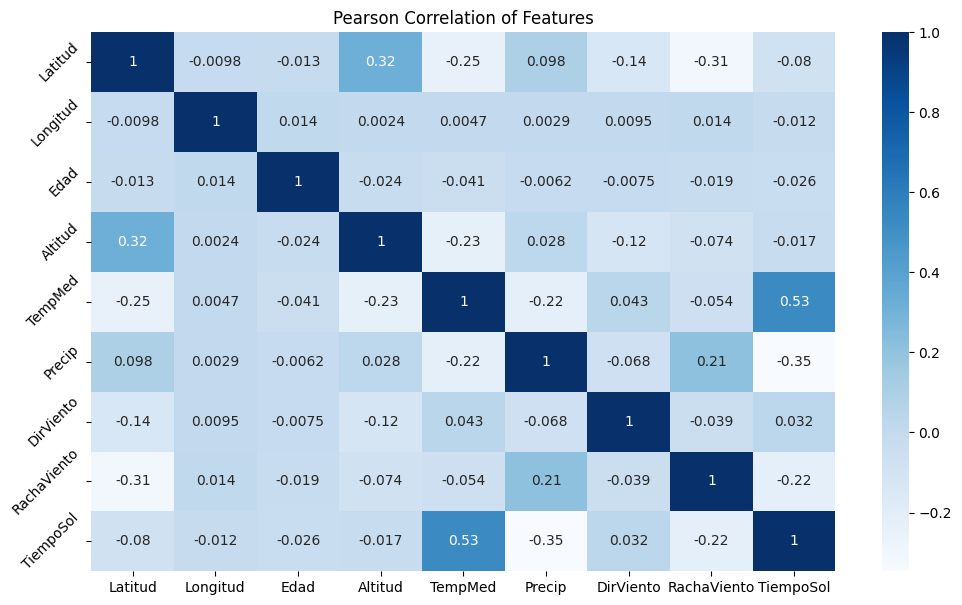

In [19]:
correlation_matrix(num_vars)

**VARIABLES SELECCIONADAS:** 

- **Categóricas:** Pronostico, Reanimación
- **Numéricas:** Edad, Altitud, TempMed, Precip, DirViento, RachaViento y TiempoSol

### <span style=color:darkblue>Modelo de clustering - Kprototyes</span>

+ Ya tenemos las variables categóricas y numéricas seleccionadas para nuestro modelo, de modo que las introduciremos en el modelo. Anterior a ello, normalizaremos los datos numéricos para que se encuentren en la misma escala. 

In [20]:
ahogamientos_df_1 = ahogamientos_df[['Edad', "Pronostico", "Reanimacion", \
                                     'Altitud', 'TempMed', 'Precip',\
                                   'DirViento', 'RachaViento', 'TiempoSol']]
ahogamientos_df_1.head(3)

,Edad,Pronostico,Reanimacion,Altitud,TempMed,Precip,DirViento,RachaViento,TiempoSol
2,47.0,Ahogamiento mortal,Recuperacion de cadaver,251,5.4,36.6,26.0,18.1,0.0
3,33.0,Rescate y traslado a supervisión médica,Sin Reanimacion,251,5.4,36.6,26.0,18.1,0.0
5,63.0,Ahogamiento mortal,SVA por SEM,24,19.6,0.0,3.0,8.9,9.1


In [21]:
# Seleccionar solo las columnas numéricas
num_cols = ahogamientos_df_1.select_dtypes(include = ['float64', 'int64']).columns

# Normalizar las columnas numéricas
scaler = MinMaxScaler()
ahogamientos_df_1[num_cols] = scaler.fit_transform(ahogamientos_df_1[num_cols])
    
ahogamientos_df_1.head(2)

/var/folders/f4/f_hhbl4s7hb5ldn8l8lf6kzr0000gn/T/ipykernel_2243/1522120692.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ahogamientos_df_1[num_cols] = scaler.fit_transform(ahogamientos_df_1[num_cols])


,Edad,Pronostico,Reanimacion,Altitud,TempMed,Precip,DirViento,RachaViento,TiempoSol
2,0.484211,Ahogamiento mortal,Recuperacion de cadaver,0.220745,0.180282,0.266764,0.255102,0.514563,0.0
3,0.336842,Rescate y traslado a supervisión médica,Sin Reanimacion,0.220745,0.180282,0.266764,0.255102,0.514563,0.0


Categorical column: ['Pronostico', 'Reanimacion']
Posición de columnas categóricas: [1, 2]
Cluster initiation: 1
Cluster initiation: 2
Cluster initiation: 3
Cluster initiation: 4
Cluster initiation: 5
Cluster initiation: 6
Cluster initiation: 7
Cluster initiation: 8
Cluster initiation: 9


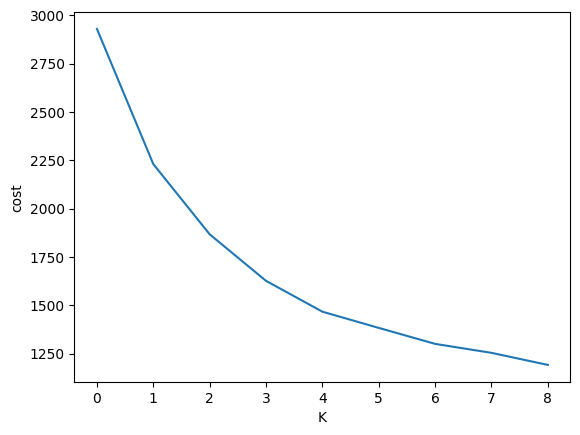

In [22]:
# KPROTOTYPES - Model 1

# Obtener la posicion de las columnas categoricas
cat_col_pos = [ahogamientos_df_1.columns.get_loc(col) for col in list(ahogamientos_df_1.select_dtypes('object').columns)]
print ( 'Categorical column: {}'.format(list(ahogamientos_df_1.select_dtypes('object').columns))) 
print ( 'Posición de columnas categóricas: {}'.format(cat_col_pos))

# Convertir el dataframe a una matriz
matrix_df = ahogamientos_df_1.to_numpy()

# Método para detectar k óptimo
cost = []
for cluster in range(1, 10):
    try:
        kprototype = KPrototypes(n_jobs = -1, n_clusters = cluster, init = 'Huang', random_state = 0)
        kprototype.fit_predict(matrix_df, categorical = cat_col_pos)
        cost.append(kprototype.cost_)
        print('Cluster initiation: {}'.format(cluster))
    except:
        break

plt.plot(cost)
plt.xlabel('K')
plt.ylabel('cost')
plt.show()

In [23]:
# Detectamos el número de clusters 
cost_knee = KneeLocator(
        x=range(1,10), 
        y= cost, 
        S=0.1, curve="convex", direction="decreasing", online=True)

K_cost = cost_knee.elbow   
print("elbow at k =", f'{K_cost:.0f} clusters')

elbow at k = 4 clusters


In [24]:
# Construimos el modelo Kprototype con 4 clsuter
kprototype = KPrototypes(n_jobs = -1, n_clusters = 4, init = 'Huang', random_state = 0)
ahogamientos_df_1['clusters']= kprototype.fit_predict(matrix_df, categorical = cat_col_pos)

/var/folders/f4/f_hhbl4s7hb5ldn8l8lf6kzr0000gn/T/ipykernel_2243/3239281089.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ahogamientos_df_1['clusters']= kprototype.fit_predict(matrix_df, categorical = cat_col_pos)


In [25]:
# Predecimos las etiquetas del cluster de cada observación
label = kprototype.fit_predict(matrix_df, categorical = cat_col_pos)
print(label)

[3 3 0 ... 0 0 0]


### <span style=color:darkblue>Análisis</span>

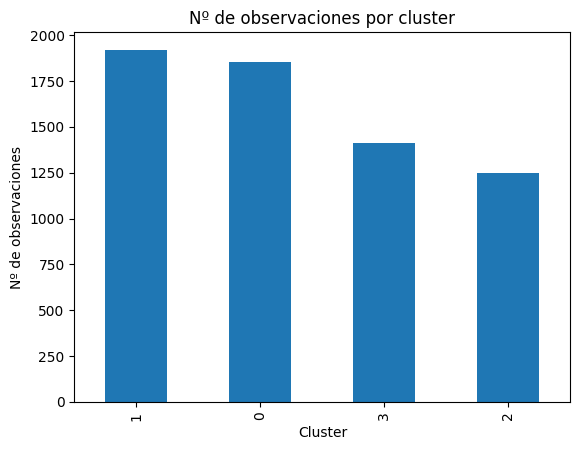

In [26]:
# Cantidad de observaciones para cada cluster
ahogamientos_df_1['clusters'].value_counts().plot(kind='bar')
plt.ylabel("Nº de observaciones")
plt.xlabel("Cluster")
plt.title("Nº de observaciones por cluster")
plt.show()

In [27]:
# Número de observaciones por cluster
ahogamientos_df_1["clusters"].value_counts()

1    1920
0    1856
3    1413
2    1247
Name: clusters, dtype: int64

In [28]:
# Revertimos el valor normalizado de las variables numéricas 
ahogamientos_df_1[num_cols] = scaler.inverse_transform(ahogamientos_df_1[num_cols])

/var/folders/f4/f_hhbl4s7hb5ldn8l8lf6kzr0000gn/T/ipykernel_2243/1841173557.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ahogamientos_df_1[num_cols] = scaler.inverse_transform(ahogamientos_df_1[num_cols])


In [29]:
# Estadísticas de la media para los datos numéricos
ahogamientos_df_1.groupby('clusters').mean(numeric_only=True)

,Edad,Altitud,TempMed,Precip,DirViento,RachaViento,TiempoSol
clusters,,,,,,,
0,64.522091,124.794720,23.437769,0.158136,16.489224,9.991595,10.843373
1,22.944271,174.262500,22.885260,0.881771,17.475521,10.209062,10.189063
2,44.709703,82.556536,22.298957,0.377225,98.823577,9.962630,9.317562
3,49.206653,227.014154,15.055272,5.305237,19.929229,11.464402,3.757396


In [30]:
# Estadísticas de la moda para los datos categóricos
ahogamientos_df_1.groupby(['clusters']).agg(lambda x: pd.Series.mode(x).iat[0])[['Pronostico','Reanimacion']]

,Pronostico,Reanimacion
clusters,,
0,Ahogamiento mortal,RCP basica SOS y SVA por SEM
1,Rescate sin consecuencias,Sin Reanimacion
2,Ahogamiento mortal,Sin Reanimacion
3,Ahogamiento mortal,Recuperacion de cadaver


**RESULTADOS:** 

- Nos encontramos con 4 grupos diferenciados:


+ El primer grupo suele asociarse a gente mayor sobre los 65 años en el que el ahogamiento acaba siendo mortal y la reanimación se hace mediante RCP basica y SVA por SEM. La temperatura media es de 23 grados, con poca precipitación y con bastantes horas de sol.
 

+ El segundo grupo suele asociarse a gente joven sobre los 23 años en el que se realiza un rescate sin consecuencias y sin la necesidad de reanimación. La temperatura media es de 22 grados, con poca precipitación y con bastantes horas de sol.
 
 
+ El tercer grupo suele asociarse a gente adulta sobre los 45 años en el que el ahogamiento acaba siendo mortal  y sin la necesidad de reanimación. La temperatura media es de 22 grados, con poca precipitación y con bastantes horas de sol.
   
   
+ El cuarto grupo suele asociarse a gente adulta sobre los 50 años en el que el ahogamiento acaba siendo mortal  y con la recuperación del cadáver. La temperatura media es de 15 grados, con buena precipitación y con pocas horas de sol. Este tipo de ahogamiento podria estar más familiarizado con una riada, inundación, etc.

## <span style=color:darkblue>SEGUNDA APROXIMACIÓN</span>

+ Imputación de los valores nans de la variable Edad 

### <span style=color:darkblue>Limpieza de los datos</span>

+ Hay columnas que de por si no son relevantes a la hora de aplicar algoritmos de aprendizaje automático como lo son los identificadores o variables que son explicadas por otras:

    - **IdAhogado:** es un identificador
    - **IdPersona:** es un identificador
    - **Indicador:** es un identificador 
    - **Localidad:** queda explicada por CCAA y con menos categorías
    - **Provincia:** queda explicada por CCAA y con menos categorías
    - **Fecha, Hora, Titular, Enlace1, Estación**: no aporta información

In [31]:
# Eliminamos las columnas que estamos 100% seguros que no aportan valor
ahogamientos_df = ahogamientos.copy()
ahogamientos_df.drop(["IdAhogado", "IdPersona","Indicador", "Localidad", \
                      "Provincia", "Fecha", "Hora", "Titular", "Enlace1", "Estacion"], axis = 1, inplace = True)
ahogamientos_df.head(2)

,CCAA,Latitud,Longitud,Sexo,Edad,Nacionalidad,Origen,Extraccion,Causa,TipoAhogamiento,Factor,Intervencion,Pronostico,Localizacion,Riesgo,Reanimacion,Vigilancia,Actividad,Deteccion,Altitud,TempMed,Precip,TempMin,TempMax,DirViento,VelMedViento,RachaViento,TiempoSol,PresionMax,PresionMin
0,Cataluña,41.130523,1.395311,NaN,NaN,España,NaN,Embarcación de rescate,NaN,Posible Ahogamiento,NaN,Recuperación de cadaver,Ahogamiento mortal,Franja costera o alta mar,NaN,Recuperacion de cadaver,No vigilado,NaN,Ciudadano,50,10.0,0.0,8.0,12.1,30.0,4.4,22.8,3.9,1010.0,1000.9
1,Andalucía,36.519991,-6.287258,NaN,NaN,España,NaN,Ciudadano,NaN,Posible Ahogamiento,NaN,Recuperación de cadaver,Ahogamiento no mortal con hospitalizacion,Playas sin vigilancia,NaN,SVA por SEM,No vigilado,Natación recreativa,Ciudadano,2,12.2,0.2,9.2,15.3,32.0,3.3,9.4,NaN,1017.0,1011.4


In [32]:
# 8015 observaciones y 30 columnas
ahogamientos_df.shape

(8015, 30)

+ De las variables restantes pueden haber algunas más interesantes que otras para el modelo clustering k-prototypes. Para ello es importante conocer los valores faltantes que nos puede ayudar a determinar que variables son relevantes y cuáles no.

In [33]:
round(ahogamientos_df.isna().sum()/ahogamientos_df.shape[0],4) * 100

CCAA                0.00
Latitud             0.00
Longitud            0.00
Sexo                4.97
Edad               19.70
Nacionalidad        1.16
Origen             43.87
Extraccion          1.32
Causa              28.10
TipoAhogamiento     0.30
Factor             58.22
Intervencion        0.97
Pronostico          0.26
Localizacion        0.00
Riesgo             61.37
Reanimacion         2.83
Vigilancia          0.34
Actividad           4.15
Deteccion           1.71
Altitud             0.00
TempMed             0.42
Precip              4.63
TempMin             0.42
TempMax             0.36
DirViento           2.28
VelMedViento        2.01
RachaViento         2.28
TiempoSol           7.70
PresionMax          0.71
PresionMin          0.70
dtype: float64

+ Hay ciertas variables que pueden ser importantes para revelar patrones de comportamiento como lo son el origen, la causa, el factor y el riesgo de ahogamiento pero que mantienen demasiados valores faltantes y que para esta segunda aproximación nos desharemos de ellas. 


+ Por otro lado, la variable edad tiene aproximadamente un 20% de valores faltantes, y para esta segunda aproximación imputaremos los valores con su media. 


+ Para las variables categóricas realizaremos imputación de missings con la moda, ya que el número de valores faltantes es muy bajo.


+ Para las variables meteorológicas realizaremos imputación de missings sobre la mediana, ya que el número de valores faltantes es muy bajo.

In [34]:
# Realizamos imputación de missings sobre la variable edad con la mediana
ahogamientos_df["Edad"] = ahogamientos_df["Edad"].fillna(ahogamientos_df["Edad"].median())

In [35]:
# Primera prueba eliminando ORIGEN, CAUSA, FACTOR Y RIESGO
ahogamientos_df.drop(["Origen", "Causa",'Factor', "Riesgo"], axis = 1, inplace = True)

In [36]:
# Imputación de missings con el valor más frecuente
no_data_columns = ["Sexo", "Nacionalidad", "Extraccion", "TipoAhogamiento", "Intervencion", "Pronostico", "Reanimacion", "Vigilancia", "Actividad", "Deteccion"]
      
for var in no_data_columns:
    moda = ahogamientos_df[var].mode().iloc[0]
    ahogamientos_df[var] = ahogamientos_df[var].fillna(moda)

In [37]:
# Realizamos imputación de missings sobre las variables meteorologicas
median_imputation = ["TempMed", "Precip", "TempMin", "TempMax", "DirViento",\
"VelMedViento", "RachaViento","TiempoSol", "PresionMax", "PresionMin"]

# Calculo de la mediana de cada variable
medians = ahogamientos_df[median_imputation].median()

for median in median_imputation:
    ahogamientos_df[median] = ahogamientos_df[median].fillna(medians[median])

In [38]:
# Mantenemos 8015 observaciones, pero 26 columnas
ahogamientos_df.shape

(8015, 26)

+ Previamente a realizar técnicas de aprendizaje automático habíamos analizado si había diferencias significativas en el número de ahogamientos dependiendo del grupo de edad. Para ello vamos asociar cada grupo de edad un valor entre 1-5 dependiendo al grupo de edad al que pertenece.


+ Hay que ir con cuidado a la hora de introducirla en el modelo, ya que está altamente correlacionada con la variable edad. 

In [39]:
# Variable que asigna valores entre 1 y 5 dependiendo al grupo que pertenece
conditions = [
    (ahogamientos_df['Edad'] > 0) & (ahogamientos_df['Edad'] <= 15),
    (ahogamientos_df['Edad'] >= 16) & (ahogamientos_df['Edad'] <= 30),
    (ahogamientos_df['Edad'] >= 31) & (ahogamientos_df['Edad'] <= 45),
    (ahogamientos_df['Edad'] >= 46) & (ahogamientos_df['Edad'] <= 60),
    (ahogamientos_df['Edad'] >= 61)
]

values = [1, 2, 3, 4, 5]

ahogamientos_df['GrupoEdad'] = np.select(conditions, values)

+ Nos queda un último paso y es el de convertir las variables categóricas a 'object' y las variables numéricas a "float", para aquellas variables que no tienen el tipo de dato correcto.

In [40]:
# Variable Latitud y Longitud
ahogamientos_df[["Latitud", "Longitud"]] = ahogamientos_df[["Latitud", "Longitud"]].apply(pd.to_numeric, errors = 'coerce')

### <span style=color:darkblue>Selección de variables</span>

+ Una vez tenemos los datos que queremos tener en cuenta y limpios procedemos a seleccionar aquellas variables que van a participar dentro del algoritmo kprototype

In [41]:
ahogamientos_df.head(3)

,CCAA,Latitud,Longitud,Sexo,Edad,Nacionalidad,Extraccion,TipoAhogamiento,Intervencion,Pronostico,Localizacion,Reanimacion,Vigilancia,Actividad,Deteccion,Altitud,TempMed,Precip,TempMin,TempMax,DirViento,VelMedViento,RachaViento,TiempoSol,PresionMax,PresionMin,GrupoEdad
0,Cataluña,41.130523,1.395311,Hombre,46.0,España,Embarcación de rescate,Posible Ahogamiento,Recuperación de cadaver,Ahogamiento mortal,Franja costera o alta mar,Recuperacion de cadaver,No vigilado,Natación recreativa,Ciudadano,50,10.0,0.0,8.0,12.1,30.0,4.4,22.8,3.9,1010.0,1000.9,4
1,Andalucía,36.519991,-6.287258,Hombre,46.0,España,Ciudadano,Posible Ahogamiento,Recuperación de cadaver,Ahogamiento no mortal con hospitalizacion,Playas sin vigilancia,SVA por SEM,No vigilado,Natación recreativa,Ciudadano,2,12.2,0.2,9.2,15.3,32.0,3.3,9.4,9.6,1017.0,1011.4,4
2,País Vasco,43.317215,-1.977996,Hombre,47.0,España,Cuerpo de Seguridad o Emergencias,Ahogamiento secundario a accidente,Recuperación de cadaver,Ahogamiento mortal,"Puertos, embarcaderos, amarres",Recuperacion de cadaver,No vigilado,Circulación en vehiculo,"Acompañante, familiar, amigo",251,5.4,36.6,3.8,7.0,26.0,8.9,18.1,0.0,977.5,968.1,4


#### <span style=color:darkblue>Datos categóricos</span>

Feature 0: 77.868890
Feature 1: 76.396000
Feature 2: 99.526222
Feature 3: 156.509071
Feature 4: 472.645201
Feature 5: 119.584143
Feature 6: 2898.119825
Feature 7: 281.329161
Feature 8: 1201.135140
Feature 9: 129.188685
Feature 10: 184.208252
Feature 11: 245.258546


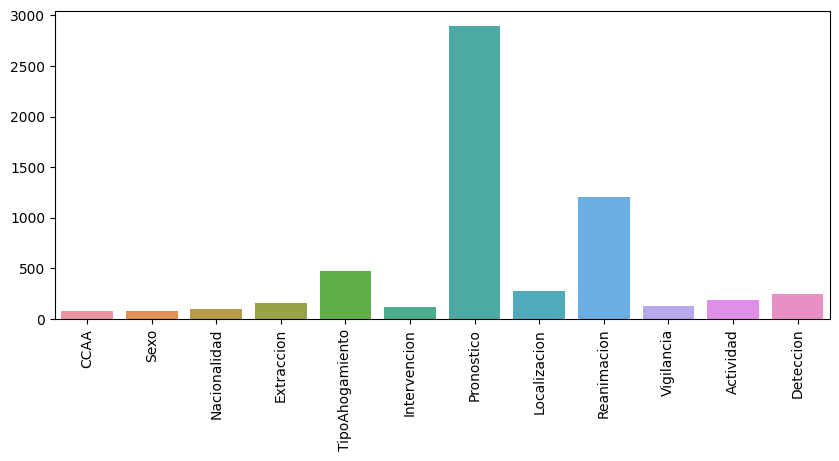

In [42]:
# Seleccionamos las variables categóricas
cat_var_importance(ahogamientos_df)

+ Se observa como las variables más relevantes para el modelo son: Pronostico, Reanimación y TipoAhogamiento. Le siguen variables como Detección, Localización y Actividad con menor relevancia.

#### <span style=color:darkblue>Datos numéricos</span>

In [43]:
# Seleccionamos únicamente variables numéricas
num_vars = ahogamientos_df.select_dtypes(include = ['float64', 'int64'])
num_vars = num_vars.iloc[:, :-1]
num_vars.head()

,Latitud,Longitud,Edad,Altitud,TempMed,Precip,TempMin,TempMax,DirViento,VelMedViento,RachaViento,TiempoSol,PresionMax,PresionMin
0,41.130523,1.395311,46.0,50,10.0,0.0,8.0,12.1,30.0,4.4,22.8,3.9,1010.0,1000.9
1,36.519991,-6.287258,46.0,2,12.2,0.2,9.2,15.3,32.0,3.3,9.4,9.6,1017.0,1011.4
2,43.317215,-1.977996,47.0,251,5.4,36.6,3.8,7.0,26.0,8.9,18.1,0.0,977.5,968.1
3,43.317215,-1.977996,33.0,251,5.4,36.6,3.8,7.0,26.0,8.9,18.1,0.0,977.5,968.1
4,29.225448,-13.502007,46.0,24,19.6,0.0,15.2,24.0,3.0,3.9,8.9,9.1,1011.0,1008.5


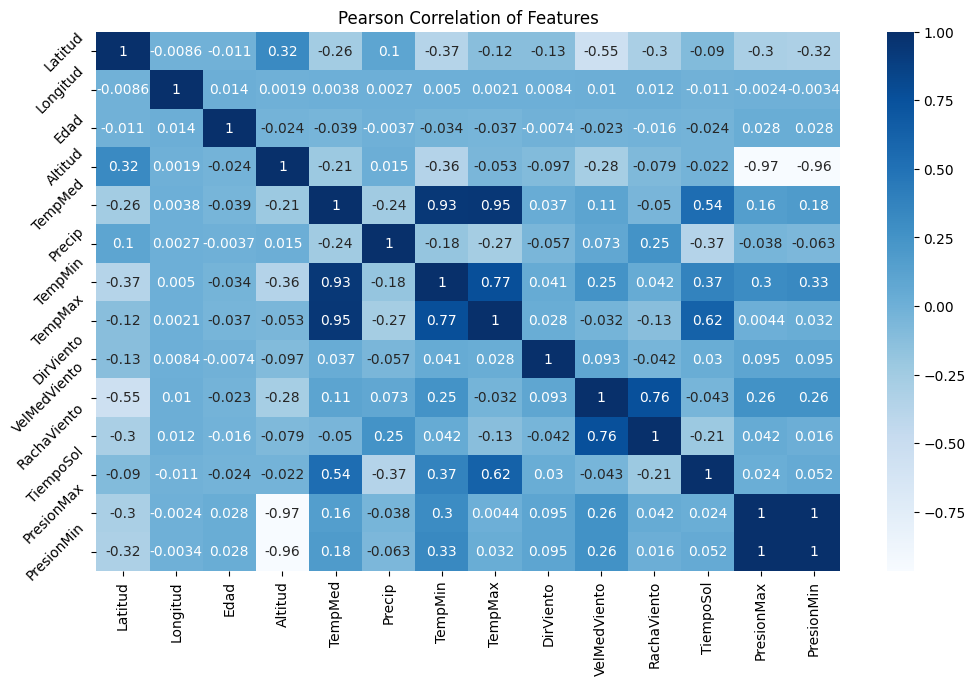

In [47]:
# Miramos la correlación entre las variables
correlation_matrix(num_vars)

+ Podemos ver varias variables con correlaciones muy altas entre ellas que pueden hacer que nuestro modelo interprete incorrectamente, por lo que debemos seleccionar:


  - La temperatura media tiene correlaciones muy altas con las variables temperatuda mínima y máxima como es de esperar, ya que cuando la temperatura máxima y mínima de un día frío es baja, es de esperar que la temperatura media del día también lo sea y viceversa con las temperaturas para un día caluroso.
    
    
  - La velocidad media del viento y la racha de viento tienen una correlación del 75%, de modo que solo nos quedaremos con la racha del viento, ya que la variable velocidad media del viento está fuertemente correlacionada con la variable altitud, aunque nos podríamos quedar con velocidad media del viento.
 
    
    
  - La variable TempSol esta correlacionada con la temperatura media, pero al no ser una relación fuerte la mantendremos en el modelo.
    
    
  - La altitud esta intrísicamente relacionada con la presión mínima y máxima, ya que a menor altitud mayor presión y viceversa. Por lo que decidimos quedarnos únicamente con la altitud, ya que presion max y min están a su vez relacionadas porque cuando en una sube, la otra baja. 

In [48]:
# Eliminamos las variables que están altamente correlacionadas
columns = ["TempMin", "TempMax", "VelMedViento", "PresionMax", "PresionMin"]
num_vars = num_vars.drop(columns, axis = 1)

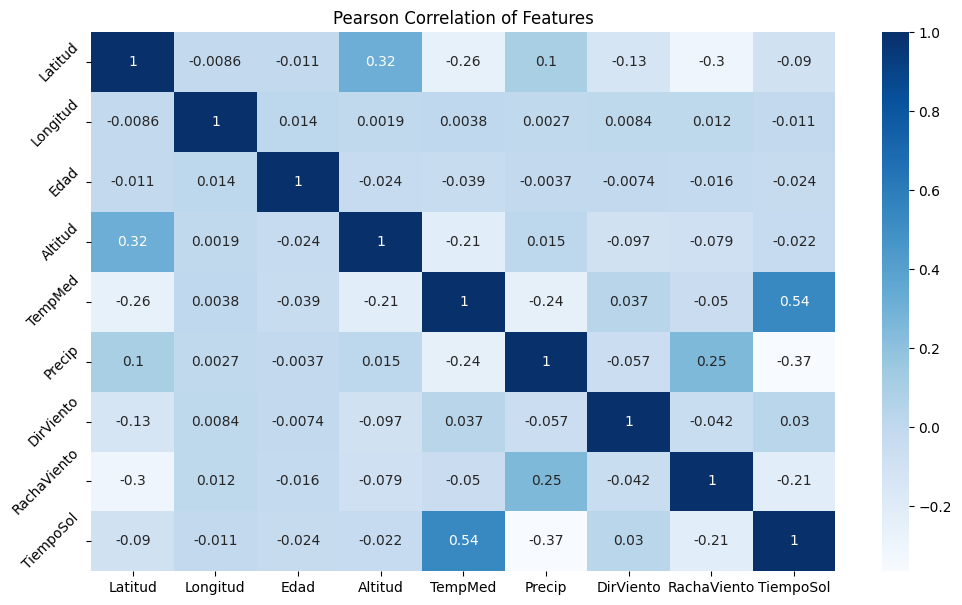

In [49]:
# Matriz de correlaciones
correlation_matrix(num_vars)

**VARIABLES SELECCIONADAS:** 

- **Categóricas:** Pronostico, Reanimación, TipoAhogamiento
- **Numéricas:** Edad, Altitud, TempMed, Precip, DirViento, RachaViento y TiempoSol

### <span style=color:darkblue>Modelo de clustering - Kprototyes</span>

+ Ya tenemos las variables categóricas y numéricas seleccionadas para nuestro modelo, de modo que las introduciremos en el modelo. Anterior a ello, normalizaremos los datos numéricos para que se encuentren en la misma escala. 

In [63]:
ahogamientos_df_2 = ahogamientos_df[["Edad", "Pronostico", "Reanimacion", "TipoAhogamiento",
                                     'Altitud', 'TempMed', 'Precip',\
                                   'DirViento', 'RachaViento', 'TiempoSol']]
ahogamientos_df_2.head(3)

,Edad,Pronostico,Reanimacion,TipoAhogamiento,Altitud,TempMed,Precip,DirViento,RachaViento,TiempoSol
0,46.0,Ahogamiento mortal,Recuperacion de cadaver,Posible Ahogamiento,50,10.0,0.0,30.0,22.8,3.9
1,46.0,Ahogamiento no mortal con hospitalizacion,SVA por SEM,Posible Ahogamiento,2,12.2,0.2,32.0,9.4,9.6
2,47.0,Ahogamiento mortal,Recuperacion de cadaver,Ahogamiento secundario a accidente,251,5.4,36.6,26.0,18.1,0.0


In [64]:
# Seleccionar solo las columnas numéricas
num_cols = ahogamientos_df_2.select_dtypes(include = ['float64', 'int64']).columns

# Normalizar las columnas numéricas
scaler = MinMaxScaler()
ahogamientos_df_2[num_cols] = scaler.fit_transform(ahogamientos_df_2[num_cols])
ahogamientos_df_2.head(2)

/var/folders/f4/f_hhbl4s7hb5ldn8l8lf6kzr0000gn/T/ipykernel_2243/118485858.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ahogamientos_df_2[num_cols] = scaler.fit_transform(ahogamientos_df_2[num_cols])


,Edad,Pronostico,Reanimacion,TipoAhogamiento,Altitud,TempMed,Precip,DirViento,RachaViento,TiempoSol
0,0.473684,Ahogamiento mortal,Recuperacion de cadaver,Posible Ahogamiento,0.042553,0.309859,0.000000,0.295918,0.666667,0.263514
1,0.473684,Ahogamiento no mortal con hospitalizacion,SVA por SEM,Posible Ahogamiento,0.000000,0.371831,0.001458,0.316327,0.233010,0.648649


Categorical column: ['Pronostico', 'Reanimacion', 'TipoAhogamiento']
Posición de columnas categóricas: [1, 2, 3]
Cluster initiation: 1
Cluster initiation: 2
Cluster initiation: 3
Cluster initiation: 4
Cluster initiation: 5
Cluster initiation: 6
Cluster initiation: 7
Cluster initiation: 8
Cluster initiation: 9


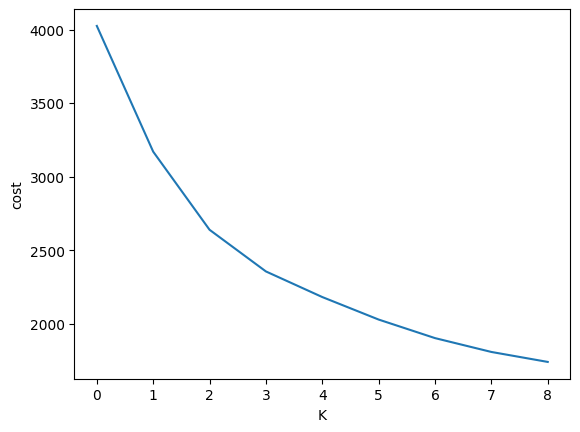

In [65]:
# KPROTOTYPES

# Obtener la posicion de las columnas categoricas
cat_col_pos = [ahogamientos_df_2.columns.get_loc(col) for col in list(ahogamientos_df_2.select_dtypes('object').columns)]
print ( 'Categorical column: {}'.format(list(ahogamientos_df_2.select_dtypes('object').columns))) 
print ( 'Posición de columnas categóricas: {}'.format(cat_col_pos))

# Convertir el dataframe a una matriz
matrix_df = ahogamientos_df_2.to_numpy()

# Método para detectar k óptimo
cost = []
for cluster in range(1, 10):
    try:
        kprototype = KPrototypes(n_jobs = -1, n_clusters = cluster, init = 'Huang', random_state = 0)
        kprototype.fit_predict(matrix_df, categorical = cat_col_pos)
        cost.append(kprototype.cost_)
        print('Cluster initiation: {}'.format(cluster))
    except:
        break

plt.plot(cost)
plt.xlabel('K')
plt.ylabel('cost')
plt.show()

In [66]:
# Detectamos el número de clusters perfecto
cost_knee = KneeLocator(
        x=range(1,10), 
        y=cost, 
        S=0.1, curve="convex", direction="decreasing", online=True)

K_cost = cost_knee.elbow   
print("elbow at k =", f'{K_cost:.0f} clusters')

elbow at k = 3 clusters


In [69]:
# Construimos el modelo Kprototype con 3 clsuter
kprototype = KPrototypes(n_jobs = -1, n_clusters = 3, init = 'Huang', random_state = 0)
ahogamientos_df_2['clusters']= kprototype.fit_predict(matrix_df, categorical = cat_col_pos)

/var/folders/f4/f_hhbl4s7hb5ldn8l8lf6kzr0000gn/T/ipykernel_2243/4181949925.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ahogamientos_df_2['clusters']= kprototype.fit_predict(matrix_df, categorical = cat_col_pos)


In [70]:
# Predecimos las etiquetas del cluster de cada observación
label = kprototype.fit_predict(matrix_df, categorical = cat_col_pos)
print(label)

[1 0 1 ... 1 1 1]


### <span style=color:darkblue>Análisis</span>

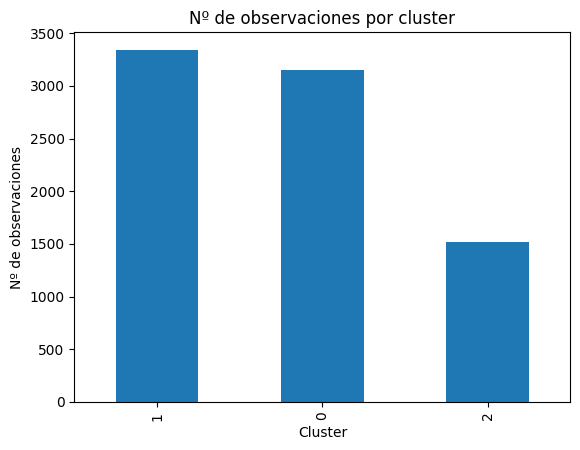

In [71]:
# Cantidad de observaciones para cada cluster
ahogamientos_df_2['clusters'].value_counts().plot(kind='bar')
plt.ylabel("Nº de observaciones")
plt.xlabel("Cluster")
plt.title("Nº de observaciones por cluster")
plt.show()

In [72]:
# Número de observaciones por cluster
ahogamientos_df_2["clusters"].value_counts()

1    3342
0    3153
2    1520
Name: clusters, dtype: int64

In [73]:
# Revertimos el valor normalizado de las variables numéricas 
ahogamientos_df_2[num_cols] = scaler.inverse_transform(ahogamientos_df_2[num_cols])

/var/folders/f4/f_hhbl4s7hb5ldn8l8lf6kzr0000gn/T/ipykernel_2243/1939770721.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ahogamientos_df_2[num_cols] = scaler.inverse_transform(ahogamientos_df_2[num_cols])


In [74]:
# Estadísticas de la media para los datos numéricos
ahogamientos_df_2.groupby('clusters').mean(numeric_only=True)

,Edad,Altitud,TempMed,Precip,DirViento,RachaViento,TiempoSol
clusters,,,,,,,
0,35.027593,153.886457,20.619791,2.514240,17.758325,10.503647,8.408088
1,54.744165,168.423100,20.898564,1.630850,17.459605,10.475943,8.692400
2,44.950658,91.907895,21.985000,0.661316,98.826316,9.935197,9.148289


In [75]:
# Estadísticas de la moda para los datos categóricos
ahogamientos_df_2.groupby(['clusters']).agg(lambda x: pd.Series.mode(x).iat[0])[['Pronostico',
                    'Reanimacion', 'TipoAhogamiento']]

,Pronostico,Reanimacion,TipoAhogamiento
clusters,,,
0,Rescate sin consecuencias,Sin Reanimacion,Perdida de Control
1,Ahogamiento mortal,Recuperacion de cadaver,Ahogado con sintomas de aspiración de agua
2,Ahogamiento mortal,Sin Reanimacion,Perdida de Control


**RESULTADOS:** 

- Nos encontramos con 3 grupos diferenciados:


+ El primer grupo suele asociarse a gente adulta joven sobre los 35 años en el que es un rescate sin consecuencias y sin necesidad de reanimación debido a la pérdida de control. La temperatura media es de 20 grados, con algo de precipitación y con relativas horas de sol.
 

+ El segundo grupo suele asociarse a gente adulta sobre los 55 años en el que se realiza un rescate por ahogamiento mortal con recuperación del cadáver debido a aspiración de agua. La temperatura media es de 20 grados, con poca precipitación y con relativas horas de sol.
 
 
+ El tercer grupo suele asociarse a gente adulta sobre los 45 años en el que el ahogamiento acaba siendo mortal  y sin la necesidad de reanimación debido a la pérdida de control. La temperatura media es de 22 grados, con poca precipitación y con relativas horas de sol.
   

## <span style=color:darkblue>TERCERA APROXIMACIÓN </span>

+ Añadimos las variables Origen, Causa y Factor, pero sin incluir el Riesgo, ya que tiene demasiados valores faltantes y además se complementan valores parecidos con el resto de variables. 

### <span style=color:darkblue>Limpieza de los datos</span>

+ Hay columnas que de por si no son relevantes a la hora de aplicar algoritmos de aprendizaje automático como lo son los identificadores o variables que son explicadas por otras:

    - **IdAhogado:** es un identificador
    - **IdPersona:** es un identificador
    - **Indicador:** es un identificador 
    - **Localidad:** queda explicada por CCAA y con menos categorías
    - **Provincia:** queda explicada por CCAA y con menos categorías
    - **Fecha, Hora, Titular, Enlace1, Estación**: no aporta información

In [76]:
# Eliminamos las columnas que estamos 100% seguros que no aportan valor
ahogamientos_df = ahogamientos.copy()
ahogamientos_df.drop(["IdAhogado", "IdPersona","Indicador", "Localidad", \
                      "Provincia", "Fecha", "Hora", "Titular", "Enlace1", "Estacion"], axis = 1, inplace = True)
ahogamientos_df.head(2)

,CCAA,Latitud,Longitud,Sexo,Edad,Nacionalidad,Origen,Extraccion,Causa,TipoAhogamiento,Factor,Intervencion,Pronostico,Localizacion,Riesgo,Reanimacion,Vigilancia,Actividad,Deteccion,Altitud,TempMed,Precip,TempMin,TempMax,DirViento,VelMedViento,RachaViento,TiempoSol,PresionMax,PresionMin
0,Cataluña,41.130523,1.395311,NaN,NaN,España,NaN,Embarcación de rescate,NaN,Posible Ahogamiento,NaN,Recuperación de cadaver,Ahogamiento mortal,Franja costera o alta mar,NaN,Recuperacion de cadaver,No vigilado,NaN,Ciudadano,50,10.0,0.0,8.0,12.1,30.0,4.4,22.8,3.9,1010.0,1000.9
1,Andalucía,36.519991,-6.287258,NaN,NaN,España,NaN,Ciudadano,NaN,Posible Ahogamiento,NaN,Recuperación de cadaver,Ahogamiento no mortal con hospitalizacion,Playas sin vigilancia,NaN,SVA por SEM,No vigilado,Natación recreativa,Ciudadano,2,12.2,0.2,9.2,15.3,32.0,3.3,9.4,NaN,1017.0,1011.4


In [77]:
# 8015 observaciones y 30 columnas
ahogamientos_df.shape

(8015, 30)

+ De las variables restantes pueden haber algunas más interesantes que otras para el modelo clustering k-prototypes. Para ello es importante conocer los valores faltantes que nos puede ayudar a determinar que variables son relevantes y cuáles no.

In [78]:
round(ahogamientos_df.isna().sum()/ahogamientos_df.shape[0],4) * 100

CCAA                0.00
Latitud             0.00
Longitud            0.00
Sexo                4.97
Edad               19.70
Nacionalidad        1.16
Origen             43.87
Extraccion          1.32
Causa              28.10
TipoAhogamiento     0.30
Factor             58.22
Intervencion        0.97
Pronostico          0.26
Localizacion        0.00
Riesgo             61.37
Reanimacion         2.83
Vigilancia          0.34
Actividad           4.15
Deteccion           1.71
Altitud             0.00
TempMed             0.42
Precip              4.63
TempMin             0.42
TempMax             0.36
DirViento           2.28
VelMedViento        2.01
RachaViento         2.28
TiempoSol           7.70
PresionMax          0.71
PresionMin          0.70
dtype: float64

+ Hay ciertas variables que pueden ser importantes para revelar patrones de comportamiento como lo son el origen, la causa, el factor y el riesgo de ahogamiento pero que mantienen demasiados valores faltantes y que para esta tercera aproximación nos desharemos del Riesgo pero imputaremos los valores de Origen, Factor y Causa. 


+ Por otro lado, la variable Edad tiene aproximadamente un 20% de valores faltantes, y para esta tercera aproximación nos desharemos de los valores nans. 


+ Para las variables categóricas realizaremos imputación de missings con la moda, ya que el número de valores faltantes es muy bajo.


+ Para las variables meteorológicas realizaremos imputación de missings sobre la mediana, ya que el número de valores faltantes es muy bajo.

In [79]:
# Eliminamos los valores en que la variable Edad tiene Nans por conveniencia
ahogamientos_df = ahogamientos_df.dropna(subset = ["Edad"])

# Eliminamos las variables Factor y Riesgo por almacenar demasiados valores faltantes
# Primera prueba eliminando ORIGEN Y CAUSA
ahogamientos_df.drop(["Riesgo"], axis = 1, inplace = True)

In [80]:
# Imputación de missings con el valor más frecuente
no_data_columns = ["Sexo", "Nacionalidad", "Origen", "Factor", "Causa","Extraccion", "TipoAhogamiento", "Intervencion", "Pronostico", "Reanimacion", "Vigilancia", "Actividad", "Deteccion"]
      
for var in no_data_columns:
    moda = ahogamientos_df[var].mode().iloc[0]
    ahogamientos_df[var] = ahogamientos_df[var].fillna(moda)

In [81]:
# Realizamos imputación de missings sobre las variables meteorologicas
median_imputation = ["TempMed", "Precip", "TempMin", "TempMax", "DirViento",\
"VelMedViento", "RachaViento","TiempoSol", "PresionMax", "PresionMin"]

# Calculo de la mediana de cada variable
medians = ahogamientos_df[median_imputation].median()

for median in median_imputation:
    ahogamientos_df[median] = ahogamientos_df[median].fillna(medians[median])

In [82]:
# Variable que asigna valores entre 1 y 5 dependiendo al grupo que pertenece
conditions = [
    (ahogamientos_df['Edad'] > 0) & (ahogamientos_df['Edad'] <= 15),
    (ahogamientos_df['Edad'] >= 16) & (ahogamientos_df['Edad'] <= 30),
    (ahogamientos_df['Edad'] >= 31) & (ahogamientos_df['Edad'] <= 45),
    (ahogamientos_df['Edad'] >= 46) & (ahogamientos_df['Edad'] <= 60),
    (ahogamientos_df['Edad'] >= 61)
]

values = [1, 2, 3, 4, 5]

ahogamientos_df['GrupoEdad'] = np.select(conditions, values)

In [83]:
# Variable Latitud y Longitud
ahogamientos_df[["Latitud", "Longitud"]] = ahogamientos_df[["Latitud", "Longitud"]].apply(pd.to_numeric, errors = 'coerce')

### <span style=color:darkblue>Selección de variables</span>

+ Una vez tenemos los datos que queremos tener en cuenta y limpios procedemos a seleccionar aquellas variables que van a participar dentro del algoritmo

In [84]:
# Carga de datos
ahogamientos_df.head(3)

,CCAA,Latitud,Longitud,Sexo,Edad,Nacionalidad,Origen,Extraccion,Causa,TipoAhogamiento,Factor,Intervencion,Pronostico,Localizacion,Reanimacion,Vigilancia,Actividad,Deteccion,Altitud,TempMed,Precip,TempMin,TempMax,DirViento,VelMedViento,RachaViento,TiempoSol,PresionMax,PresionMin,GrupoEdad
2,País Vasco,43.317215,-1.977996,Hombre,47.0,España,Local,Cuerpo de Seguridad o Emergencias,Accidente de Trafico,Ahogamiento secundario a accidente,"Edad, Enfermedad, Enfermedad Mental",Recuperación de cadaver,Ahogamiento mortal,"Puertos, embarcaderos, amarres",Recuperacion de cadaver,No vigilado,Circulación en vehiculo,"Acompañante, familiar, amigo",251,5.4,36.6,3.8,7.0,26.0,8.9,18.1,0.0,977.5,968.1,4
3,País Vasco,43.317215,-1.977996,Hombre,33.0,España,Local,No preciso extraccion,Accidente de Trafico,Perdida de Control,"Edad, Enfermedad, Enfermedad Mental",Recuperación de cadaver,Rescate y traslado a supervisión médica,"Puertos, embarcaderos, amarres",Sin Reanimacion,No vigilado,Circulación en vehiculo,"Acompañante, familiar, amigo",251,5.4,36.6,3.8,7.0,26.0,8.9,18.1,0.0,977.5,968.1,3
5,Canarias,28.485031,-14.094721,Hombre,63.0,Otro,Extranjero,Helicoptero,"Accidente, caída o zambullida accidentales",Ahogamiento secundario a accidente,Peligrosidad del entorno,Rescate por personal adiestrado con equipamiento,Ahogamiento mortal,Playas sin vigilancia,SVA por SEM,No vigilado,Natación recreativa,"Acompañante, familiar, amigo",24,19.6,0.0,15.2,24.0,3.0,3.9,8.9,9.1,1011.0,1008.5,5


In [85]:
# 6436 observaciones y 30 columnas
ahogamientos_df.shape

(6436, 30)

#### <span style=color:darkblue>Datos categóricos</span>

Feature 0: 85.589672
Feature 1: 28.744553
Feature 2: 27.550063
Feature 3: 9.538296
Feature 4: 275.030926
Feature 5: 834.802646
Feature 6: 244.721151
Feature 7: 642.098435
Feature 8: 63.752047
Feature 9: 3035.348964
Feature 10: 195.069313
Feature 11: 1001.211849
Feature 12: 130.307084
Feature 13: 142.451610
Feature 14: 265.970848


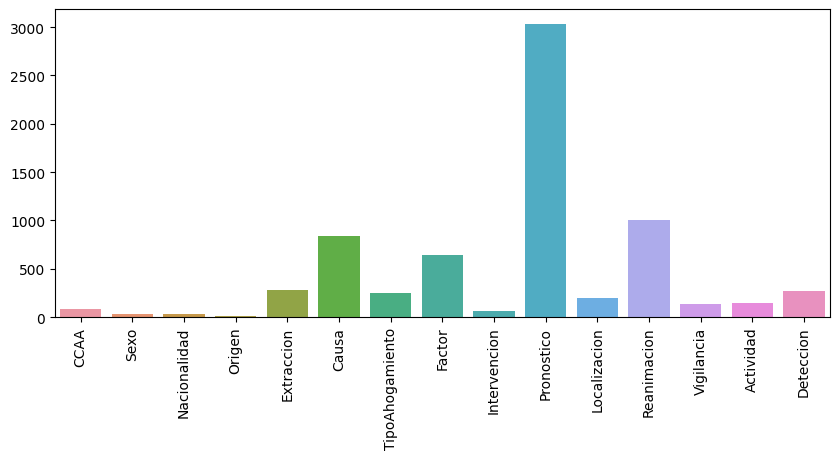

In [86]:
# Seleccionamos las variables categóricas
cat_var_importance(ahogamientos_df)

+ Se observa como las variables más relevantes para el modelo son: Pronostico, Reanimación, Causa, Factor. Luego hay otras variables como Extracción y Detección que tienen un menor peso.

#### <span style=color:darkblue>Datos numéricos</span>

In [87]:
# Seleccionamos únicamente variables numéricas
num_vars = ahogamientos_df.select_dtypes(include = ['float64', 'int64'])
num_vars = num_vars.iloc[:, :-1]
num_vars.head()

,Latitud,Longitud,Edad,Altitud,TempMed,Precip,TempMin,TempMax,DirViento,VelMedViento,RachaViento,TiempoSol,PresionMax,PresionMin
2,43.317215,-1.977996,47.0,251,5.4,36.6,3.8,7.0,26.0,8.9,18.1,0.0,977.5,968.1
3,43.317215,-1.977996,33.0,251,5.4,36.6,3.8,7.0,26.0,8.9,18.1,0.0,977.5,968.1
5,28.485031,-14.094721,63.0,24,19.6,0.0,15.2,24.0,3.0,3.9,8.9,9.1,1011.0,1008.5
6,28.485031,-14.094721,53.0,24,19.6,0.0,15.2,24.0,3.0,3.9,8.9,9.1,1011.0,1008.5
7,28.396314,-16.651826,32.0,32,19.2,0.0,17.4,20.9,2.0,1.4,4.7,6.5,1011.8,1008.0


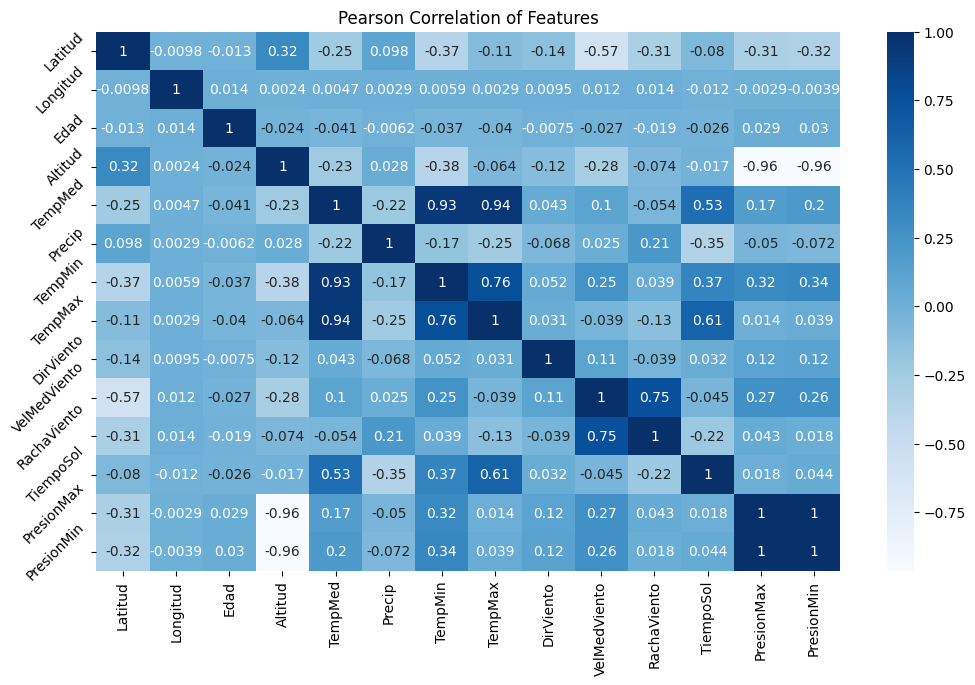

In [88]:
# Miramos la correlación entre las variables
correlation_matrix(num_vars)

+ Podemos ver varias variables con correlaciones muy altas entre ellas que pueden hacer que nuestro modelo interprete incorrectamente, por lo que debemos seleccionar:


  - La temperatura media tiene correlaciones muy altas con las variables temperatuda mínima y máxima como es de esperar, ya que cuando la temperatura máxima y mínima de un día frío es baja, es de esperar que la temperatura media del día también lo sea y viceversa con las temperaturas para un día caluroso.
    
    
  - La velocidad media del viento y la racha de viento tienen una correlación del 75%, de modo que solo nos quedaremos con la racha del viento, ya que la variable velocidad media del viento está fuertemente correlacionada con la variable altitud, aunque nos podríamos quedar con velocidad media del viento.
 
    
    
  - La variable TempSol esta correlacionada con la temperatura media, pero al no ser una relación fuerte la mantendremos en el modelo.
    
    
  - La altitud esta intrísicamente relacionada con la presión mínima y máxima, ya que a menor altitud mayor presión y viceversa. Por lo que decidimos quedarnos únicamente con la altitud, ya que presion max y min están a su vez relacionadas porque cuando en una sube, la otra baja. 

In [89]:
# Eliminamos las variables que están altamente correlacionadas
columns = ["TempMin", "TempMax", "VelMedViento", "PresionMax", "PresionMin"]
num_vars = num_vars.drop(columns, axis = 1)

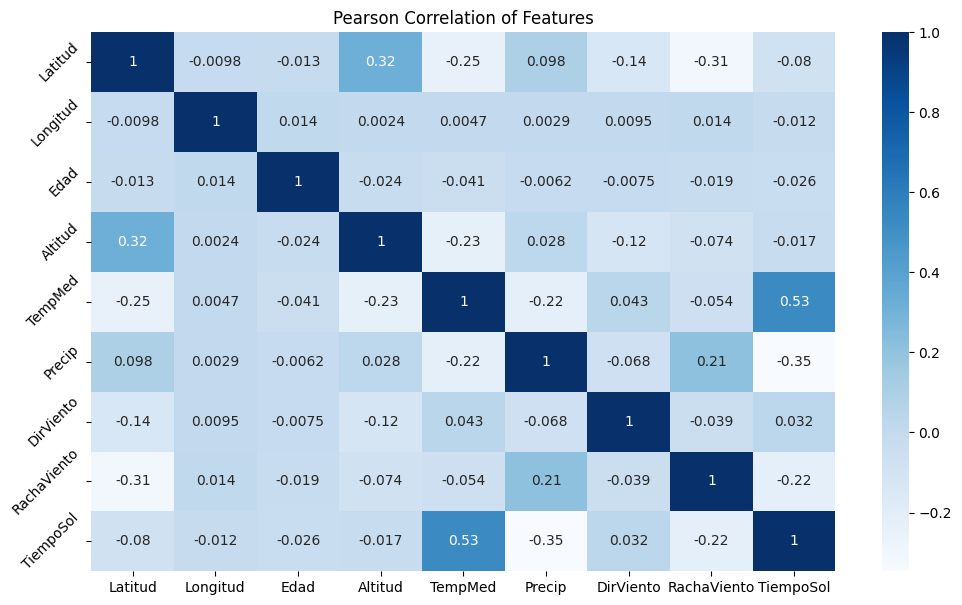

In [90]:
# Matriz de correlaciones
correlation_matrix(num_vars)

**VARIABLES SELECCIONADAS:** 

- **Categóricas:** Pronostico, Reanimación, Causa, Factor
- **Numéricas:** Edad, Altitud, TempMed, Precip, DirViento, RachaViento y TiempoSol

### <span style=color:darkblue>Modelo de clustering - Kprototyes</span>

+ Ya tenemos las variables categóricas y numéricas seleccionadas para nuestro modelo, de modo que las introduciremos en el modelo. Anterior a ello, normalizaremos los datos numéricos para que se encuentren en la misma escala. 

In [91]:
ahogamientos_df_3 = ahogamientos_df[['Edad', "Pronostico", "Reanimacion", "Causa", "Factor",\
                                     'Altitud', 'TempMed', 'Precip',\
                                   'DirViento', 'RachaViento', 'TiempoSol']]
ahogamientos_df_3.head(3)

,Edad,Pronostico,Reanimacion,Causa,Factor,Altitud,TempMed,Precip,DirViento,RachaViento,TiempoSol
2,47.0,Ahogamiento mortal,Recuperacion de cadaver,Accidente de Trafico,"Edad, Enfermedad, Enfermedad Mental",251,5.4,36.6,26.0,18.1,0.0
3,33.0,Rescate y traslado a supervisión médica,Sin Reanimacion,Accidente de Trafico,"Edad, Enfermedad, Enfermedad Mental",251,5.4,36.6,26.0,18.1,0.0
5,63.0,Ahogamiento mortal,SVA por SEM,"Accidente, caída o zambullida accidentales",Peligrosidad del entorno,24,19.6,0.0,3.0,8.9,9.1


In [92]:
# Seleccionar solo las columnas numéricas
num_cols = ahogamientos_df_3.select_dtypes(include = ['float64', 'int64']).columns

# Normalizar las columnas numéricas
scaler = MinMaxScaler()
ahogamientos_df_3[num_cols] = scaler.fit_transform(ahogamientos_df_3[num_cols])
ahogamientos_df_3.head(2)

/var/folders/f4/f_hhbl4s7hb5ldn8l8lf6kzr0000gn/T/ipykernel_2243/3888519603.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ahogamientos_df_3[num_cols] = scaler.fit_transform(ahogamientos_df_3[num_cols])


,Edad,Pronostico,Reanimacion,Causa,Factor,Altitud,TempMed,Precip,DirViento,RachaViento,TiempoSol
2,0.484211,Ahogamiento mortal,Recuperacion de cadaver,Accidente de Trafico,"Edad, Enfermedad, Enfermedad Mental",0.220745,0.180282,0.266764,0.255102,0.514563,0.0
3,0.336842,Rescate y traslado a supervisión médica,Sin Reanimacion,Accidente de Trafico,"Edad, Enfermedad, Enfermedad Mental",0.220745,0.180282,0.266764,0.255102,0.514563,0.0


Categorical column: ['Pronostico', 'Reanimacion', 'Causa', 'Factor']
Posición de columnas categóricas: [1, 2, 3, 4]
Cluster initiation: 1
Cluster initiation: 2
Cluster initiation: 3
Cluster initiation: 4
Cluster initiation: 5
Cluster initiation: 6
Cluster initiation: 7
Cluster initiation: 8
Cluster initiation: 9


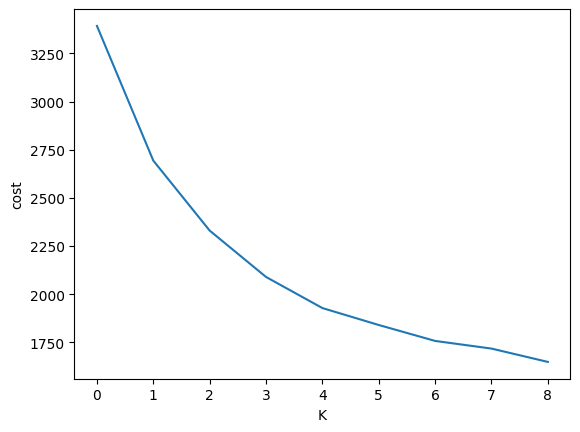

In [93]:
# KPROTOTYPES

# Obtener la posicion de las columnas categoricas
cat_col_pos = [ahogamientos_df_3.columns.get_loc(col) for col in list(ahogamientos_df_3.select_dtypes('object').columns)]
print ( 'Categorical column: {}'.format(list(ahogamientos_df_3.select_dtypes('object').columns))) 
print ( 'Posición de columnas categóricas: {}'.format(cat_col_pos))

# Convertir el dataframe a una matriz
matrix_df = ahogamientos_df_3.to_numpy()

# Método para detectar k óptimo
cost = []
for cluster in range(1, 10):
    try:
        kprototype = KPrototypes(n_jobs = -1, n_clusters = cluster, init = 'Huang', random_state = 0)
        kprototype.fit_predict(matrix_df, categorical = cat_col_pos)
        cost.append(kprototype.cost_)
        print('Cluster initiation: {}'.format(cluster))
    except:
        break

plt.plot(cost)
plt.xlabel('K')
plt.ylabel('cost')
plt.show()

In [94]:
# Detectamos el número de clusters perfecto
cost_knee = KneeLocator(
        x=range(1,10), 
        y=cost, 
        S=0.1, curve="convex", direction="decreasing", online=True)

K_cost = cost_knee.elbow   
print("elbow at k =", f'{K_cost:.0f} clusters')

elbow at k = 4 clusters


In [95]:
# Construimos el modelo Kprototype con 3 clsuter
kprototype = KPrototypes(n_jobs = -1, n_clusters = 4, init = 'Huang', random_state = 0)
ahogamientos_df_3['clusters']= kprototype.fit_predict(matrix_df, categorical = cat_col_pos)

/var/folders/f4/f_hhbl4s7hb5ldn8l8lf6kzr0000gn/T/ipykernel_2243/1244223404.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ahogamientos_df_3['clusters']= kprototype.fit_predict(matrix_df, categorical = cat_col_pos)


In [96]:
# Predecimos las etiquetas del cluster de cada observación
label = kprototype.fit_predict(matrix_df, categorical = cat_col_pos)
print(label)

[3 3 2 ... 2 2 2]


### <span style=color:darkblue>Análisis</span>

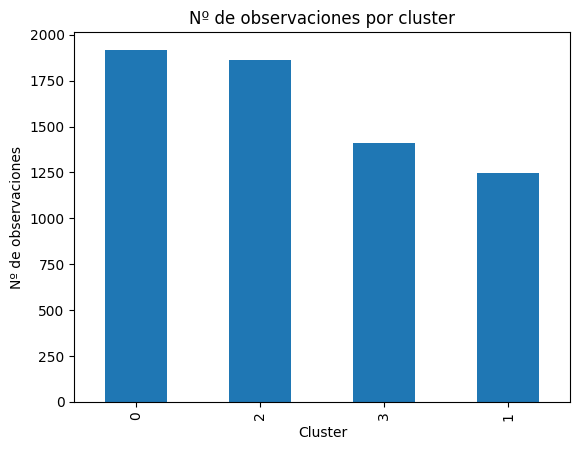

In [97]:
# Cantidad de observaciones para cada cluster
ahogamientos_df_3['clusters'].value_counts().plot(kind='bar')
plt.ylabel("Nº de observaciones")
plt.xlabel("Cluster")
plt.title("Nº de observaciones por cluster")
plt.show()

In [98]:
# Número de observaciones por cluster
ahogamientos_df_3["clusters"].value_counts()

0    1918
2    1860
3    1411
1    1247
Name: clusters, dtype: int64

In [99]:
# Revertimos el valor normalizado de las variables numéricas 
ahogamientos_df_3[num_cols] = scaler.inverse_transform(ahogamientos_df_3[num_cols])

/var/folders/f4/f_hhbl4s7hb5ldn8l8lf6kzr0000gn/T/ipykernel_2243/2540857633.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ahogamientos_df_3[num_cols] = scaler.inverse_transform(ahogamientos_df_3[num_cols])


In [100]:
# Estadísticas de la media para los datos numéricos
ahogamientos_df_3.groupby('clusters').mean(numeric_only=True)

,Edad,Altitud,TempMed,Precip,DirViento,RachaViento,TiempoSol
clusters,,,,,,,
0,22.939520,174.338373,22.885245,0.881648,17.466632,10.210740,10.189416
1,44.709703,82.556536,22.298957,0.377225,98.823577,9.962630,9.317562
2,64.472581,124.729570,23.436505,0.164839,16.493011,9.988495,10.837366
3,49.197732,227.211906,15.044295,5.304890,19.942594,11.468604,3.753863


In [101]:
# Estadísticas de la moda para los datos categóricos
ahogamientos_df_3.groupby(['clusters']).agg(lambda x: pd.Series.mode(x).iat[0])[['Pronostico',\
                   'Reanimacion', 'Causa', 'Factor']]

,Pronostico,Reanimacion,Causa,Factor
clusters,,,,
0,Rescate sin consecuencias,Sin Reanimacion,Condiciones del medio acuático,"Edad, Enfermedad, Enfermedad Mental"
1,Ahogamiento mortal,Sin Reanimacion,Condiciones del medio acuático,"Edad, Enfermedad, Enfermedad Mental"
2,Ahogamiento mortal,RCP basica SOS y SVA por SEM,Condiciones del medio acuático,"Edad, Enfermedad, Enfermedad Mental"
3,Ahogamiento mortal,Recuperacion de cadaver,Condiciones del medio acuático,"Edad, Enfermedad, Enfermedad Mental"


**RESULTADOS:** 

- Nos encontramos con 4 grupos diferenciados:


+ El primer grupo suele asociarse a gente joven sobre los 23 años en el que es un rescate sin consecuencias y sin necesidad de reanimación debido a condiciones del medio acuático. La temperatura media es de 22 grados, con poca precipitación y con bastantes horas de sol.
 

+ El segundo grupo suele asociarse a gente adulta sobre los 45 años en el que se realiza un rescate por ahogamiento mortal sin necesidad de reanimación debido a condiciones del medio acuático. La temperatura media es de 22 grados, con poca precipitación y con bastantes horas de sol.
 
 
+ El tercer grupo suele asociarse a gente mayor sobre los 65 años en el que el ahogamiento acaba siendo mortal  y realizando reanimación vía RCP basica SOS y SVA por SEM, debido a las condiciones del medio acuático. La temperatura media es de 23 grados, con poca precipitación y con bastantes horas de sol.


+ El tercer grupo suele asociarse a gente adulta sobre los 50 años en el que el ahogamiento acaba siendo mortal con recuperación del cadáver debido a las condiciones del medio acuático. La temperatura media es de 15 grados, con buena precipitación y con pocas horas de sol. Ahogamientos asociados a riadas, inundaciones, etc.

**<span style=color:red>Conclusiones</span>**

+ Hay 4 perfiles de ahogamientos claramente identificados:

+ Aquel perfil joven que el rescate no tiene consecuencias y carece de la necesidad de reanimación, donde la causa principal es el medio acuático debido a la pérdida de control.

+ Aquel perfil adulto que sufre un ahogamiento mortal sin reanimación, donde la causa principal también es el medio acuático y debido a la pérdida de control. 

+ Aquel perfil adulto que también sufre un ahogamiento mortal pero con la particularidad que no se produce tanto en playas o piscinas sino que es más en riadas o inundaciones, ya que se acaba recuperando el cadáver, siendo la causa el medio acuático y las condiciones climatológicas son de mal tiempo y precipitación.

+ Finalmente, observamos un perfil mayor que sufre un ahogamiento mortal en el cual se intenta reanimar a la víctima, también debido al medio acuático pero que acaba muriendo.